### https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2

# LOADING LIBRARIES

In [4]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_wine
np.set_printoptions(precision=4)
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Dataset 

In [46]:
# TAKE THE DATA FROM JSON --> pose = 65 ; gap = 50 ; dim = 25
with open('../Simulation/data_pos_sim_labelled_sep_motion.json') as f:
    data_dict = json.load(f)

data_list = [data_dict['LF_motion1'],data_dict['RF_motion1']]
data_array = np.array(data_list).T
temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,0,:,1],axis=0)
data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0).T
angle_array = data_array[:,:2].astype(float)

# CREATE A DATAFRAME BY WINDOWING THE RAW AND INCREMENTING THE POSITION OF THE WINDOW
rows,columns = data_array.shape
window_size = 5 # needs to be odd
half_window_size = math.floor(window_size/2)
data_window = np.zeros((rows-half_window_size*2,window_size*2+1)) #+1 for the class
corners = []
sides = []

first_corner_hit = False
second_corner_hit = False
for i in range(half_window_size,rows-half_window_size):
    temp_window = np.append(data_array[i-half_window_size:half_window_size+i+1,:].T[0],
                            data_array[i-half_window_size:half_window_size+i+1,:].T[1])
    # class 1 --> side1
    if 'corner' not in data_array[i-half_window_size+1:half_window_size+i+1-1,:].T[2] and not first_corner_hit and not second_corner_hit:
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([1]))
    # class 2 --> corner1
    elif data_array[i-half_window_size:half_window_size+i+1,:].T[2][-2] == 'corner' and not first_corner_hit and not second_corner_hit:
        first_corner_hit = True
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
    # class 4 --> corner2
    elif data_array[i-half_window_size:half_window_size+i+1,:].T[2][-2] == 'corner' and first_corner_hit and not second_corner_hit:
        second_corner_hit = True
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([4]))
    # class 2 --> corner1
    elif 'corner' in data_array[i-half_window_size+1:half_window_size+i+1-1,:].T[2] and first_corner_hit and not second_corner_hit:
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
    # class 3 --> side2
    elif 'corner' not in data_array[i-half_window_size+1:half_window_size+i+1-1,:].T[2] and first_corner_hit and not second_corner_hit:
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([3]))
    # class 4 --> corner2
    elif 'corner' in data_array[i-half_window_size+1:half_window_size+i+1-1,:].T[2] and first_corner_hit and second_corner_hit:
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([4]))
    # class 5 --> side3
    else :
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([5]))

#print(data_window)
names = []
for j in range(window_size):
    names += ["angleLF"+str(j+1)]
for j in range(window_size):
    names += ["angleRF"+str(j+1)]
names += ["class"]

# DATA FRAME PANDAS
df = pd.DataFrame(data=data_window,columns = names)
df["class"].replace({1.0: "side1", 2.0: "corner1" ,3.0: "side2", 4.0: "corner2",5.0: "side3"}, inplace=True)
df.dropna(how='all', inplace=True)
windows = df[names[:len(names)-1]]
labels = df[names[-1]]

data_window_array = np.array(data_window)
print(np.array(data_window).T[-1])
corners_pos = np.array(corners)
sides_pos = np.array(sides)

df.head()
#windows.head()
#labels.head()


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


,angleLF1,angleLF2,angleLF3,angleLF4,angleLF5,angleRF1,angleRF2,angleRF3,angleRF4,angleRF5,class
0,40.0,41.0,42.0,43.0,44.0,38.216855,39.705104,41.189086,42.669395,44.146616,side1
1,41.0,42.0,43.0,44.0,45.0,39.705104,41.189086,42.669395,44.146616,45.621328,side1
2,42.0,43.0,44.0,45.0,46.0,41.189086,42.669395,44.146616,45.621328,47.094103,side1
3,43.0,44.0,45.0,46.0,47.0,42.669395,44.146616,45.621328,47.094103,48.565513,side1
4,44.0,45.0,46.0,47.0,48.0,44.146616,45.621328,47.094103,48.565513,50.036130,side1


# Plot the positions of the finger

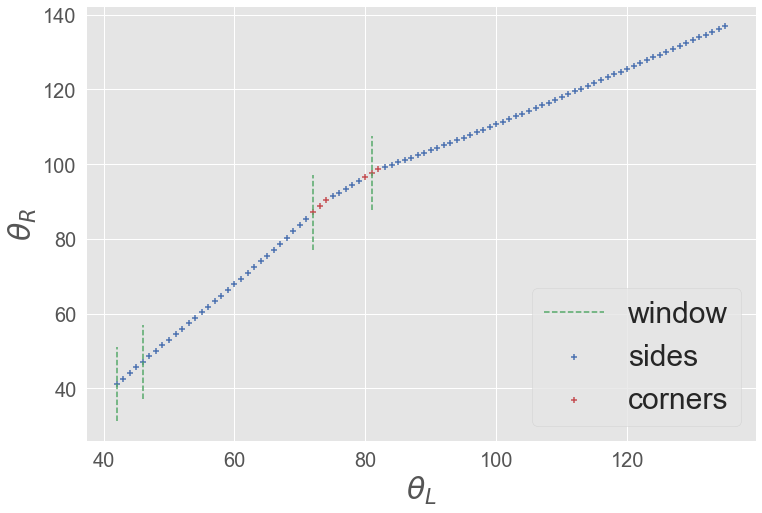

In [47]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)

plt.scatter(sides_pos.T[0],sides_pos.T[1],color='b',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1],color='r',marker='+',label='corners')
plt.plot([sides_pos.T[0][0],sides_pos.T[0][0]],
         [sides_pos.T[1][0]-10,sides_pos.T[1][0]+10],'--',color='g')
plt.plot([sides_pos.T[0][4],sides_pos.T[0][4]],
         [sides_pos.T[1][4]-10,sides_pos.T[1][4]+10],'--',color='g')
plt.plot([corners_pos.T[0][0],corners_pos.T[0][0]],
         [corners_pos.T[1][0]-10,corners_pos.T[1][0]+10],'--',color='g')
plt.plot([corners_pos.T[0][4],corners_pos.T[0][4]],
         [corners_pos.T[1][4]-10,corners_pos.T[1][4]+10],'--',color='g',label='window')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("raw_data_window_manual_class.png")

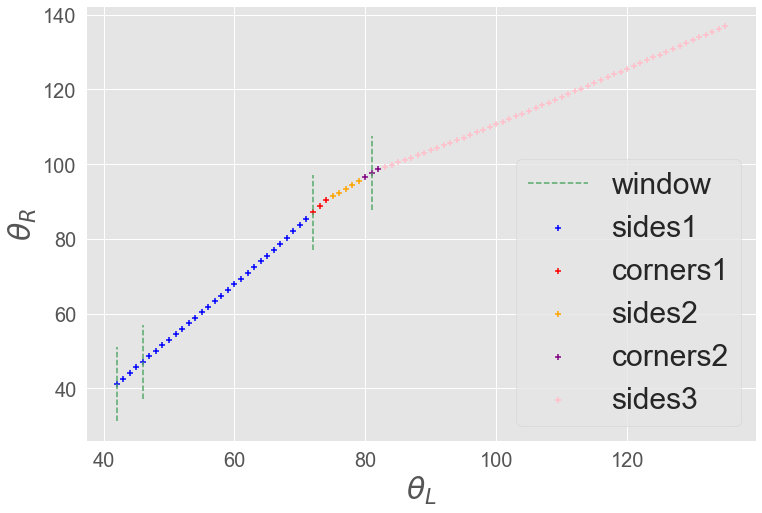

In [48]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)

plt.scatter(angle_array[half_window_size:-half_window_size].T[0][data_window_array.T[-1] == 1],
            angle_array[half_window_size:-half_window_size].T[1][data_window_array.T[-1] == 1],
            color='blue',marker='+',label='sides1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][data_window_array.T[-1] == 2],
            angle_array[half_window_size:-half_window_size].T[1][data_window_array.T[-1] == 2],
            color='red',marker='+',label='corners1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][data_window_array.T[-1] == 3],
            angle_array[half_window_size:-half_window_size].T[1][data_window_array.T[-1] == 3], 
            color='orange',marker='+',label='sides2')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][data_window_array.T[-1] == 4],
            angle_array[half_window_size:-half_window_size].T[1][data_window_array.T[-1] == 4], 
            color='purple',marker='+',label='corners2')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][data_window_array.T[-1] == 5],
            angle_array[half_window_size:-half_window_size].T[1][data_window_array.T[-1] == 5], 
            color='pink',marker='+',label='sides3')
plt.plot([sides_pos.T[0][0],sides_pos.T[0][0]],
         [sides_pos.T[1][0]-10,sides_pos.T[1][0]+10],'--',color='g')
plt.plot([sides_pos.T[0][4],sides_pos.T[0][4]],
         [sides_pos.T[1][4]-10,sides_pos.T[1][4]+10],'--',color='g')
plt.plot([corners_pos.T[0][0],corners_pos.T[0][0]],
         [corners_pos.T[1][0]-10,corners_pos.T[1][0]+10],'--',color='g')
plt.plot([corners_pos.T[0][4],corners_pos.T[0][4]],
         [corners_pos.T[1][4]-10,corners_pos.T[1][4]+10],'--',color='g',label='window')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("raw_data_window_manual_class.png")

# Standardizing the Data

useless becase here we use fittransform that handles the standardization

In [49]:
def standardize_data(arr): 
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    for column in range(columns):  
        mean = np.mean(arr[:,column])
        std = np.std(arr[:,column])
        tempArray = np.empty(0)
        for element in arr[:,column]:
            tempArray = np.append(tempArray, ((element - mean) / std))
        standardizedArray[:,column] = tempArray
    return standardizedArray

# LDA with sklearn

After formating the data we have: 
 X = 
 [[40.     41.     42.     43.     44.     38.2169 39.7051 41.1891 42.6694
  44.1466]
 [41.     42.     43.     44.     45.     39.7051 41.1891 42.6694 44.1466
  45.6213]
 [42.     43.     44.     45.     46.     41.1891 42.6694 44.1466 45.6213
  47.0941]
 [43.     44.     45.     46.     47.     42.6694 44.1466 45.6213 47.0941
  48.5655]
 [44.     45.     46.     47.     48.     44.1466 45.6213 47.0941 48.5655
  50.0361]] 
 y = 
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 3 3 3 3
 3 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
The explained variance ratio of lda is :  [9.8480e-01 1.4317e-02 7.5247e-04 1.3496e-04]


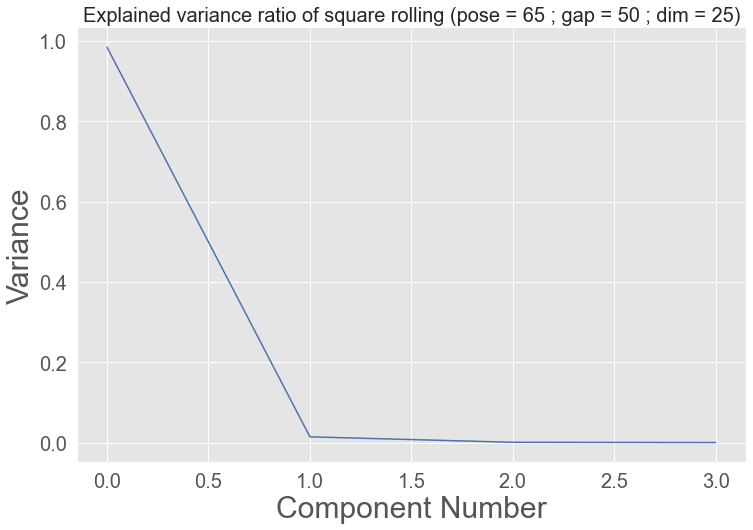

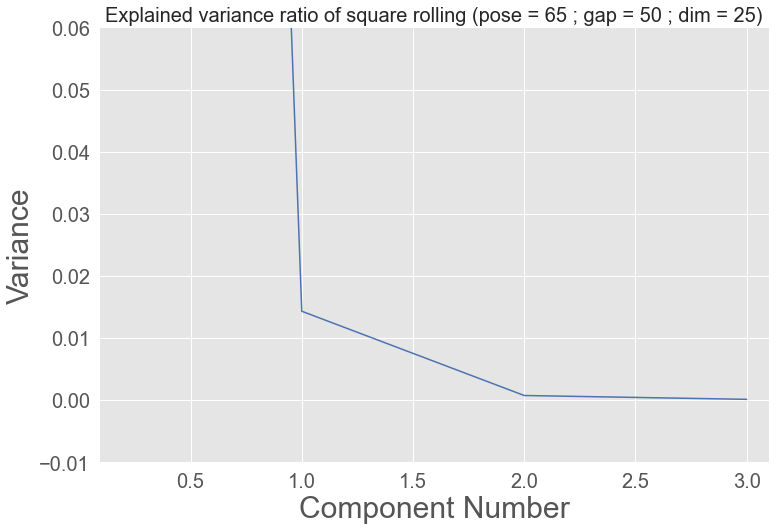

In [68]:
# Preparation of the data for LDA
# Standardizing data
X = df.iloc[:, 0:-1].values
X_std = standardize_data(X)
le = LabelEncoder()
y = le.fit_transform(df['class'])
print("After formating the data we have: \n X = \n",X[:5],'\n y = \n', y)

# Import LDA from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_X = lda.fit_transform(X_std, y)
print("The explained variance ratio of lda is : ", lda.explained_variance_ratio_)

################

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.xlabel('Component Number')
plt.ylabel('Variance')
plt.plot(lda.explained_variance_ratio_, color='b')
plt.title("Explained variance ratio of square rolling (pose = 65 ; gap = 50 ; dim = 25)", 
          fontsize =20)
#plt.savefig("1D_LDA_proj_std_angles_windowing.png")

###############

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.xlabel('Component Number')
plt.ylabel('Variance')
plt.title("Explained variance ratio of square rolling (pose = 65 ; gap = 50 ; dim = 25)",
         fontsize =20)
plt.ylim(-0.01,0.06)
plt.xlim(0.09,3.1)
plt.plot(lda.explained_variance_ratio_, color='b')
#plt.savefig("1D_LDA_proj_std_angles_windowing.png")


# Plot projection on feature vectors

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 3 3 3 3
 3 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


Text(0.5, 1.0, '2D LDA projection of square rolling (pose = 65 ; gap = 50 ; dim = 25)')

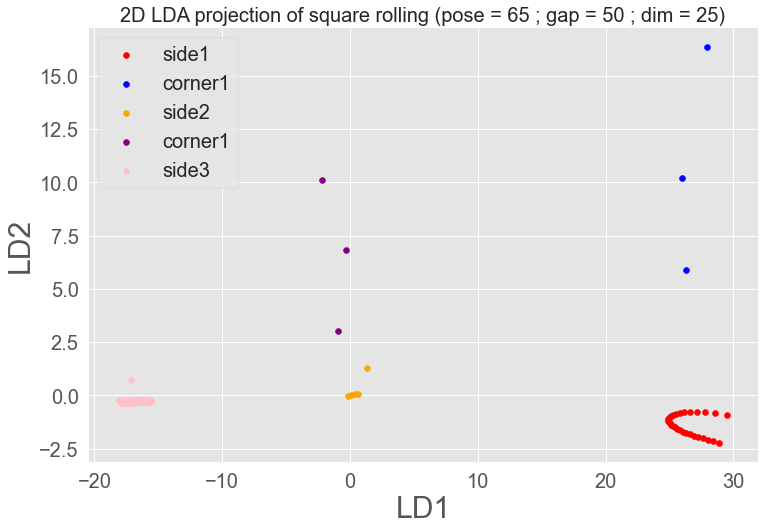

In [73]:
print(y)
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(lda_X[:,0][y==2],lda_X[:,1][y==2],color='red', label = 'side1')
plt.scatter(lda_X[:,0][y==0],lda_X[:,1][y==0],color='blue', label = 'corner1')
plt.scatter(lda_X[:,0][y==3],lda_X[:,1][y==3],color='orange', label = 'side2')
plt.scatter(lda_X[:,0][y==1],lda_X[:,1][y==1],color='purple', label = 'corner1')
plt.scatter(lda_X[:,0][y==4],lda_X[:,1][y==4],color='pink', label = 'side3')
ax.legend()
plt.title("2D LDA projection of square rolling (pose = 65 ; gap = 50 ; dim = 25)",
         fontsize = 20)

#### The 2 classes are now separated on a1D line

- But the divisions between groups is pretty obvious in this case 
- We can manually estimate it in the 1D case
- But the data can now be passed to a clustering algorithm 
- Which will have an easier job than with the original data


# Classification algorithm

# Performance of binary classification with F1-score

\begin{align}
    F1 =& \frac{2}{Precision^{-1} + Recall^{-1}} \label{f1_score}\\
    Precision =& \frac{true\;\;positive}{true\;\;positive+false\;\;positive} \label{precision} \\ 
    Recall =& \frac{true\;\;positive}{true\;\;positive+false\;\;negative} \label{recall}
\end{align}

In [78]:
def f1_score(y1,y2):
    "calculate the f1_score"
    tp = 0 # true side --> true positive
    tn = 0 # true corner --> true negative
    fp = 0 # false side --> false positive
    fn = 0 # false corner --> false negative
    for i in range(len(y2)):
        # right classisification
        if y2[i] == y1[i]:
            if y2[i] == 0:
                tp+=1 # identified a side instead of a corner
            else:
                tn+=1 # identified a corner instead of a side
        # right classification
        else:
            if y2[i] == 0:
                fp+=1 # side 
            else: 
                fp+=1 # corner
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2/(1/precision+1/recall)
    return[f1,precision,recall]

## K-means
https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

sklearn K-means uses the euclidian distance to form the clusters

In [111]:
from sklearn.cluster import KMeans

lda_fin_X = lda_X[:,:2]

# 2-means clustering 
k2means = KMeans(n_clusters=2, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k2means = k2means.fit_predict(lda_fin_X)

# 3-mens clustering
k3means = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k3means = k3means.fit_predict(lda_fin_X)

# 4-means clustering 
k4means = KMeans(n_clusters=4, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k4means = k4means.fit_predict(lda_fin_X)

# 5-mens clustering
k5means = KMeans(n_clusters=5, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k5means = k5means.fit_predict(lda_fin_X)

# 6-mens clustering
k6means = KMeans(n_clusters=6, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_k6means = k6means.fit_predict(lda_fin_X)

### Visualizing the clusters
#### 2-means

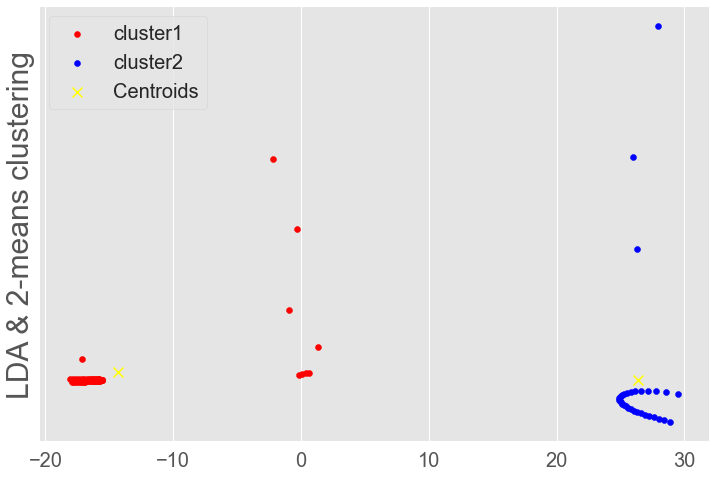

In [83]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LDA & 2-means clustering')
plt.scatter(lda_X[:,0][y_k2means==0],lda_X[:,1][y_k2means==0],color='red', label = 'cluster1')
plt.scatter(lda_X[:,0][y_k2means==1],lda_X[:,1][y_k2means==1],color='blue', label = 'cluster2')
plt.scatter(k2means.cluster_centers_[:, 0], k2means.cluster_centers_[:, 1], 
            s=100, c='yellow', marker='x',label = 'Centroids')
ax.legend()
#plt.savefig('LD1_2_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.

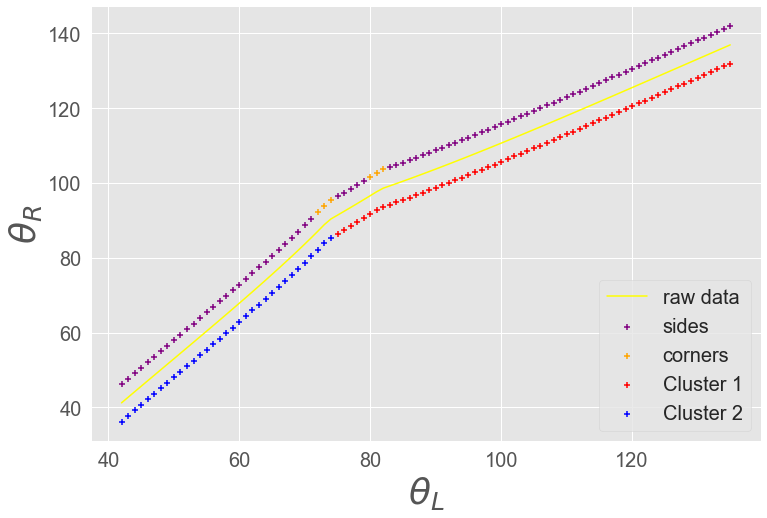

In [84]:
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='purple',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='orange',marker='+',label='corners')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k2means == 0], 
            angle_array[half_window_size:-half_window_size].T[1][y_k2means == 0]-5, 
            marker='+', c='red', label ='Cluster 1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k2means == 1], 
            angle_array[half_window_size:-half_window_size].T[1][y_k2means == 1]-5, 
            marker='+', c='blue', label ='Cluster 2')
plt.plot(angle_array[half_window_size:-half_window_size].T[0],
        angle_array[half_window_size:-half_window_size].T[1],
        color='yellow', label='raw data')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("clusters_class_raw_2_means.png")

#### 3-means clustering

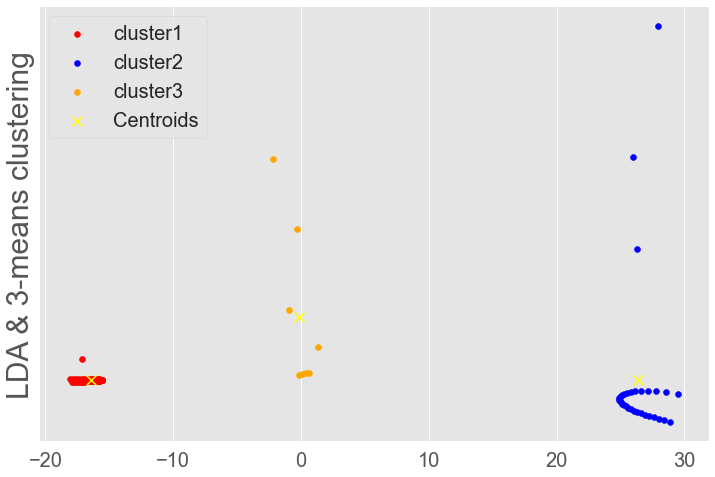

In [89]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LDA & 3-means clustering')
plt.scatter(lda_X[:,0][y_k3means==0],lda_X[:,1][y_k3means==0],color='red', label = 'cluster1')
plt.scatter(lda_X[:,0][y_k3means==1],lda_X[:,1][y_k3means==1],color='blue', label = 'cluster2')
plt.scatter(lda_X[:,0][y_k3means==2],lda_X[:,1][y_k3means==2],color='orange', label = 'cluster3')
plt.scatter(k3means.cluster_centers_[:, 0], k3means.cluster_centers_[:, 1], 
            s=100, c='yellow', marker='x',label = 'Centroids')
ax.legend()
#plt.savefig('LD1_2_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.


### Visualisation of the clusters, the classes and the raw data

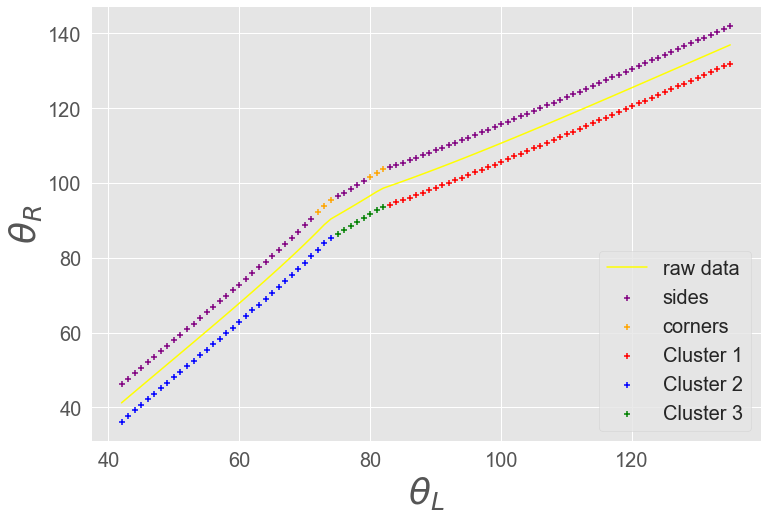

In [88]:
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='purple',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='orange',marker='+',label='corners')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 0], 
            angle_array[half_window_size:-half_window_size].T[1][y_k3means == 0]-5, 
            marker='+', c='red', label ='Cluster 1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 1], 
            angle_array[half_window_size:-half_window_size].T[1][y_k3means == 1]-5, 
            marker='+', c='blue', label ='Cluster 2')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k3means == 2], 
            angle_array[half_window_size:-half_window_size].T[1][y_k3means == 2]-5, 
            marker='+', c='green', label ='Cluster 3')
plt.plot(angle_array[half_window_size:-half_window_size].T[0],
        angle_array[half_window_size:-half_window_size].T[1],
        color='yellow', label='raw data')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("clusters_class_raw_3_means.png")

# 4-means

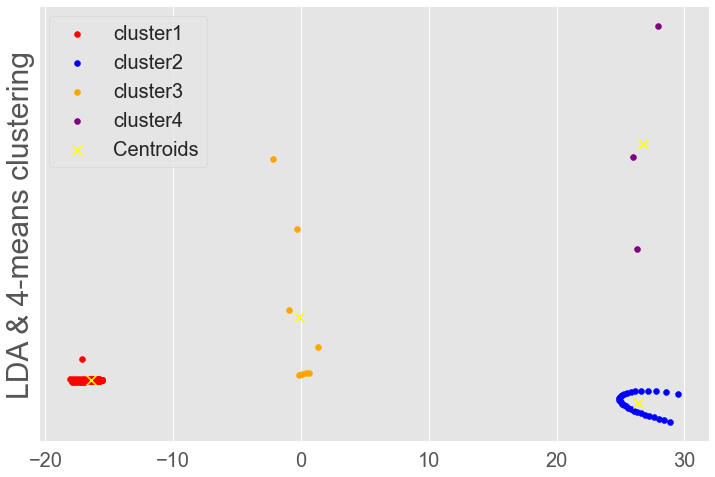

In [98]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LDA & 4-means clustering')
plt.scatter(lda_X[:,0][y_k4means==0],lda_X[:,1][y_k4means==0],color='red', label = 'cluster1')
plt.scatter(lda_X[:,0][y_k4means==1],lda_X[:,1][y_k4means==1],color='blue', label = 'cluster2')
plt.scatter(lda_X[:,0][y_k4means==2],lda_X[:,1][y_k4means==2],color='orange', label = 'cluster3')
plt.scatter(lda_X[:,0][y_k4means==3],lda_X[:,1][y_k4means==3],color='purple', label = 'cluster4')
plt.scatter(k4means.cluster_centers_[:, 0], k4means.cluster_centers_[:, 1], 
            s=100, c='yellow', marker='x',label = 'Centroids')
ax.legend()
#plt.savefig('LD1_2_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.


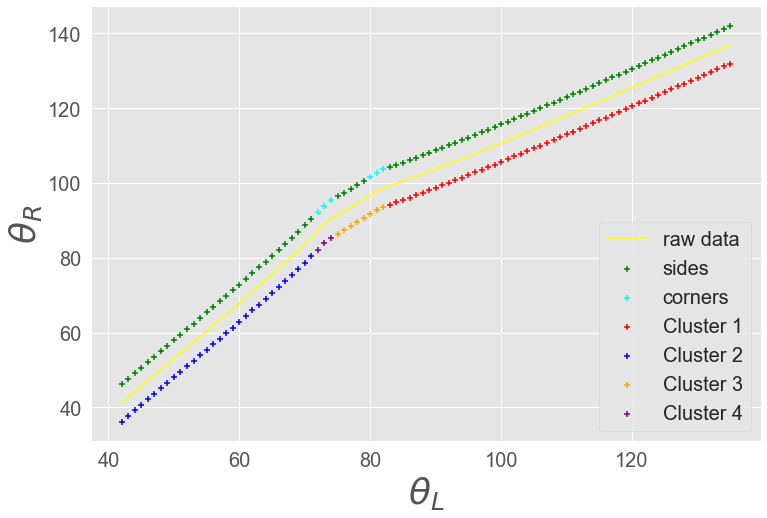

In [104]:
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='green',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='cyan',marker='+',label='corners')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k4means == 0], 
            angle_array[half_window_size:-half_window_size].T[1][y_k4means == 0]-5, 
            marker='+', c='red', label ='Cluster 1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k4means == 1], 
            angle_array[half_window_size:-half_window_size].T[1][y_k4means == 1]-5, 
            marker='+', c='blue', label ='Cluster 2')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k4means == 2], 
            angle_array[half_window_size:-half_window_size].T[1][y_k4means == 2]-5, 
            marker='+', c='orange', label ='Cluster 3')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k4means == 3], 
            angle_array[half_window_size:-half_window_size].T[1][y_k4means == 3]-5, 
            marker='+', c='purple', label ='Cluster 4')
plt.plot(angle_array[half_window_size:-half_window_size].T[0],
        angle_array[half_window_size:-half_window_size].T[1],
        color='yellow', label='raw data')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("clusters_class_raw_3_means.png")

# 5-means

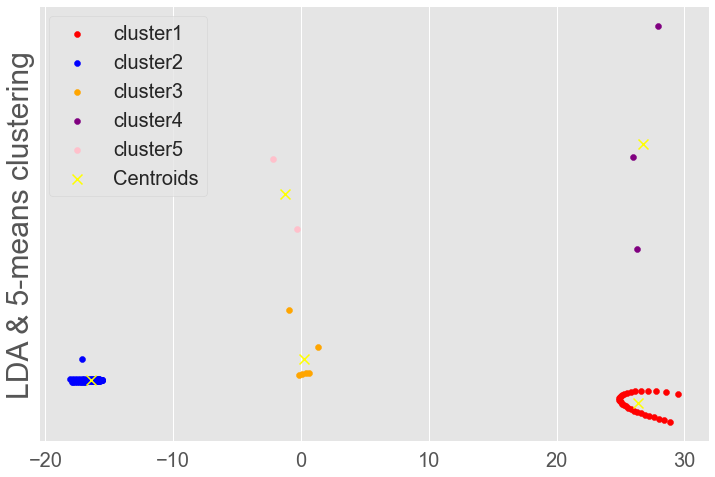

In [109]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LDA & 5-means clustering')
plt.scatter(lda_X[:,0][y_k5means==0],lda_X[:,1][y_k5means==0],color='red', label = 'cluster1')
plt.scatter(lda_X[:,0][y_k5means==1],lda_X[:,1][y_k5means==1],color='blue', label = 'cluster2')
plt.scatter(lda_X[:,0][y_k5means==2],lda_X[:,1][y_k5means==2],color='orange', label = 'cluster3')
plt.scatter(lda_X[:,0][y_k5means==3],lda_X[:,1][y_k5means==3],color='purple', label = 'cluster4')
plt.scatter(lda_X[:,0][y_k5means==4],lda_X[:,1][y_k5means==4],color='pink', label = 'cluster5')
plt.scatter(k5means.cluster_centers_[:, 0], k5means.cluster_centers_[:, 1], 
            s=100, c='yellow', marker='x',label = 'Centroids')
ax.legend()
#plt.savefig('LD1_2_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.


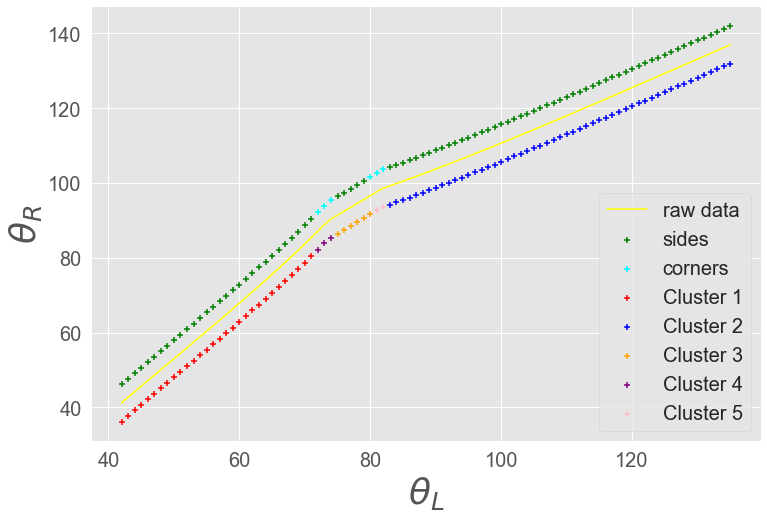

In [110]:
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(sides_pos.T[0],sides_pos.T[1]+5,color='green',marker='+',label='sides')
plt.scatter(corners_pos.T[0],corners_pos.T[1]+5,color='cyan',marker='+',label='corners')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k5means == 0], 
            angle_array[half_window_size:-half_window_size].T[1][y_k5means == 0]-5, 
            marker='+', c='red', label ='Cluster 1')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k5means == 1], 
            angle_array[half_window_size:-half_window_size].T[1][y_k5means == 1]-5, 
            marker='+', c='blue', label ='Cluster 2')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k5means == 2], 
            angle_array[half_window_size:-half_window_size].T[1][y_k5means == 2]-5, 
            marker='+', c='orange', label ='Cluster 3')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k5means == 3], 
            angle_array[half_window_size:-half_window_size].T[1][y_k5means == 3]-5, 
            marker='+', c='purple', label ='Cluster 4')
plt.scatter(angle_array[half_window_size:-half_window_size].T[0][y_k5means == 4], 
            angle_array[half_window_size:-half_window_size].T[1][y_k5means == 4]-5, 
            marker='+', c='pink', label ='Cluster 5')
plt.plot(angle_array[half_window_size:-half_window_size].T[0],
        angle_array[half_window_size:-half_window_size].T[1],
        color='yellow', label='raw data')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
#plt.savefig("clusters_class_raw_3_means.png")

# 6-means

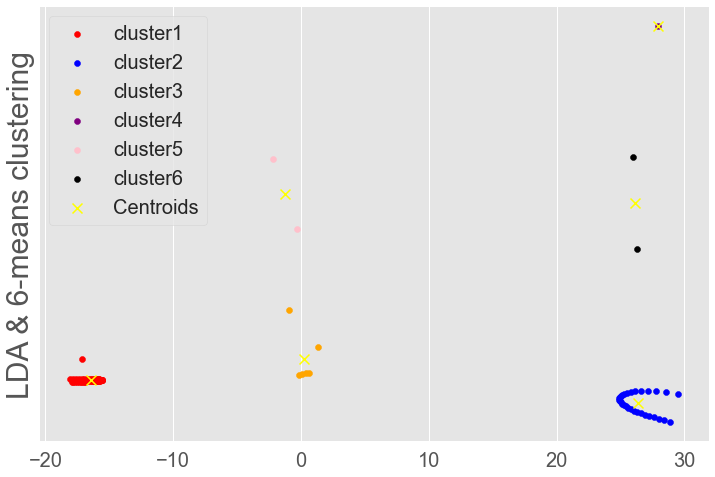

In [112]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LDA & 6-means clustering')
plt.scatter(lda_X[:,0][y_k6means==0],lda_X[:,1][y_k6means==0],color='red', label = 'cluster1')
plt.scatter(lda_X[:,0][y_k6means==1],lda_X[:,1][y_k6means==1],color='blue', label = 'cluster2')
plt.scatter(lda_X[:,0][y_k6means==2],lda_X[:,1][y_k6means==2],color='orange', label = 'cluster3')
plt.scatter(lda_X[:,0][y_k6means==3],lda_X[:,1][y_k6means==3],color='purple', label = 'cluster4')
plt.scatter(lda_X[:,0][y_k6means==4],lda_X[:,1][y_k6means==4],color='pink', label = 'cluster5')
plt.scatter(lda_X[:,0][y_k6means==5],lda_X[:,1][y_k6means==5],color='black', label = 'cluster6')
plt.scatter(k6means.cluster_centers_[:, 0], k6means.cluster_centers_[:, 1], 
            s=100, c='yellow', marker='x',label = 'Centroids')
ax.legend()
#plt.savefig('LD1_2_means_clustering.png')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.

### F1-score for k-means clustering

\begin{align}
    F1 =& \frac{2}{Precision^{-1} + Recall^{-1}} \label{f1_score}\\
    Precision =& \frac{true\;\;positive}{true\;\;positive+false\;\;positive} \label{precision} \\ 
    Recall =& \frac{true\;\;positive}{true\;\;positive+false\;\;negative} \label{recall}
\end{align}

#### 2-means clustering

In [72]:
" 0 : side ; 1 : corners"
from sklearn.metrics import f1_score
# we need to change "y" before beca
y_true = []
for i in range(y.shape[0]):
    if y[i] == 0:
        y_true += [1]
    else:
        y_true += [0]
print("The f1_score of the 2-means is : ",f1_score(y_true,y_k2means))

The f1_score of the 2-means is :  0.8235294117647058


### 3-means clustering

The f1_score of the 2-means is :  0.8235294117647058
The f1_score of the 3-means for global corner identification is :  0.888888888888889
The f1_score of the 3-means for each corner identification (micro/or accuracy) is :  0.9042553191489362


## Elbow method 
### https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

- Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
- Inertia: It is the sum of squared distances of samples to their closest cluster center.

1 : 19.011829486005347
2 : 3.703574715915781
3 : 2.1309404006455965
4 : 1.792175363970793
5 : 1.6435618590464656
6 : 1.36468008685647
7 : 1.2974543912562417
8 : 1.1394256439931094
9 : 1.0062235113434521
---------
Distortions
% decrease = 100 x (initial - current)/current
2  :  80.51963006168347
3  :  42.46260534482885
4  :  15.897443052474406
5  :  8.292352852962736
6  :  16.968133609025987
7  :  4.926113911069227
8  :  12.179907696803372
9  :  11.690287413828193


Text(0.5, 1.0, 'The Elbow Method using Distortion')

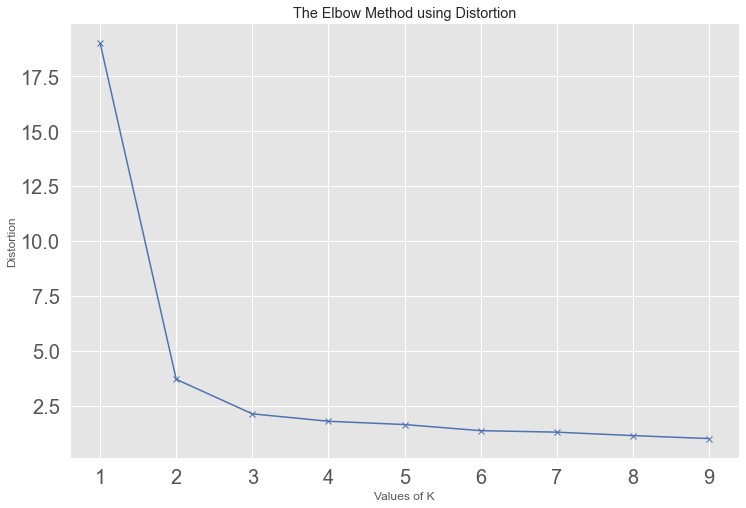

In [122]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
    y_kmeans = kmeanModel.fit_predict(lda_X)
    
    distortions.append(sum(np.min(cdist(lda_X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / lda_X.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(lda_X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / lda_X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    

for key, val in mapping1.items():
    print(f'{key} : {val}')

print("---------")
print("Distortions")
print("% decrease = 100 x (initial - current)/current")
for i in range(1,len(inertias)):
    print(i+1," : ",(distortions[i-1]-distortions[i])/distortions[i-1]*100)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

1 : 38204.58349684921
2 : 2772.08961357844
3 : 853.6653879973998
4 : 448.1549442307583
5 : 343.1841011795977
6 : 277.58228827504365
7 : 224.93655503142818
8 : 182.2262480104614
9 : 147.062284234473
---------
Inertias decrease
% decrease = 100 x (initial - current)/current
2  :  92.74409152030918
3  :  69.20498587722716
4  :  47.50227073372648
5  :  23.422890766348516
The predicted number of corners is :  2


Text(0.5, 1.0, 'The Elbow Method using Inertia')

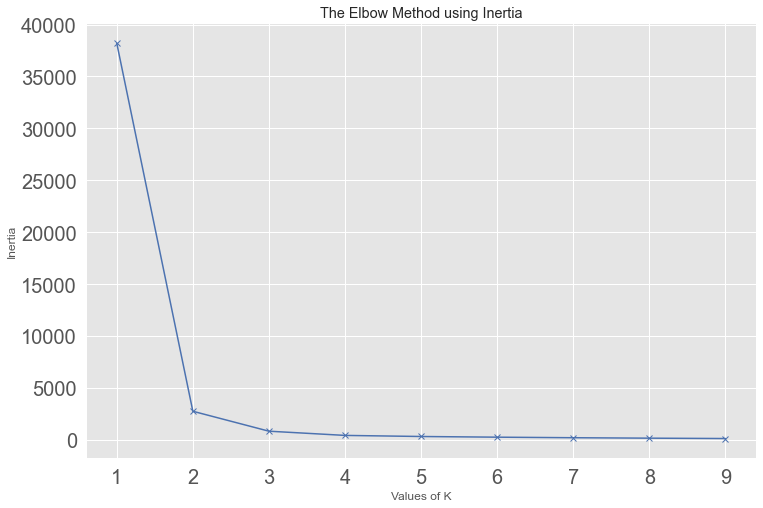

In [134]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

print("---------")
print("Inertias decrease")
print("% decrease = 100 x (initial - current)/current")
predicted_corner_number = 0
for i in range(1,len(inertias)):
    if (inertias[i-1]-inertias[i])/inertias[i-1]*100 < 20:
        predicted_corner_number = i-3
        break
    print(i+1," : ",(inertias[i-1]-inertias[i])/inertias[i-1]*100)
print("The predicted number of corners is : ",predicted_corner_number)

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

## Decision Trees

https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

## Support Vector Machine

## Naive Bayes

# In the case you want to do it manually

In [45]:
labels_feature_means = pd.DataFrame(columns=np.array(["side","corner"]))

for c, rows in df.groupby('class'):
    labels_feature_means[c] = rows.mean()
labels_feature_means 

,side,corner
angleLF1,87.869048,75.000000
angleLF2,88.869048,76.000000
angleLF3,89.869048,77.000000
angleLF4,90.869048,78.000000
angleLF5,91.869048,79.000000
angleRF1,95.710595,90.482112
angleRF2,96.715493,91.838239
angleRF3,97.724740,93.085030
angleRF4,98.738635,94.220319
angleRF5,99.757535,95.241369
